In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import snn_classifier as snn_clas

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['animal', 'nature', 'human', 'domestic', 'urban']

In [5]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    if target < 10:
        dataset.loc[index, 'h_category'] = 0
    elif target < 20:
        dataset.loc[index, 'h_category'] = 1
    elif target < 30:
        dataset.loc[index, 'h_category'] = 2
    elif target < 40:
        dataset.loc[index, 'h_category'] = 3
    elif target < 50:
        dataset.loc[index, 'h_category'] = 4

In [6]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,3
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,3
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Preprocessing
Just MFCC were sufficient in previous work.
13 coefficients together with first and second derivatives and remove first energy component.
Should yield vector of 38 features per time frame.

In [7]:
test_file = pd.DataFrame(ps.preprocess('2-102414-A-17.wav'))

In [8]:
test_file.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,21.927575,20.290780,18.206072,16.158445,14.273799,12.354932,10.169572,7.719307,5.262192,3.099848,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
1,22.382184,21.468147,20.070725,18.335122,16.396533,14.348357,12.234242,10.065163,7.851280,5.631985,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
2,23.721630,22.750234,21.206390,19.194400,16.844600,14.300204,11.703585,9.183705,6.846216,4.767270,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
3,27.081467,25.569413,23.217595,20.250900,16.935373,13.542076,10.314547,7.444653,5.058995,3.215542,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
4,27.904973,25.317398,21.752548,18.017817,14.759908,12.250736,10.353642,8.674094,6.814273,4.605797,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [9]:
c_data = pd.concat([ps.preprocess_fold(fld, dataset) for fld in range(1,6)], ignore_index=True)

In [10]:
c_data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0


In [11]:
n_categories = c_data.target.unique().size

In [12]:
c_data, scalar = du.normalize_data(c_data, 'target')
train, test = du.split_training_test(c_data, 0.2)
train_X = train.drop(columns=['target'])
train_y = train.target
test_X = test.drop(columns=['target'])
test_y = test.target

(174886,)
(485880, 1)
(485880, 38)


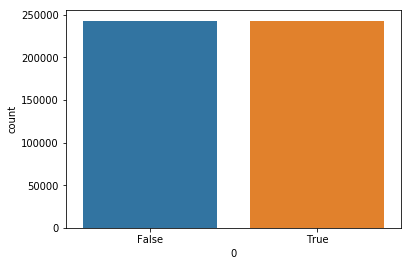

In [13]:
import seaborn as sns
xx, yy = du.balanced_supersample(train_X, train_y.between(0,10))
sns.countplot(yy[0])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
hl_shallow = {}
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
#     Get equally distributed set of positive and negative instances
    xx, yy = du.balanced_supersample(train_X, train_y.between(start_i, end_i))
    clas = KerasClassifier(build_fn=snn_clas.create_baseline, epochs=20, batch_size=128, verbose=1)
    clas.fit(xx, yy)
    clas.score(test_X, test_y.between(start_i,end_i))
    hl_shallow[h_classes[i]] = clas

(188678,)
(499672, 1)
(499672, 38)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                468       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
499672/499672 [==============================] - 31s 61us/step - loss: 0.5901 - acc: 0.6739
Epoch 2/20
499672/499672 [==============================] - 23s 45us/step - loss: 0.5530 - acc: 0.7082
Epoch 3/20
499672/499672 [==============================] - 22s 45us/step - loss: 0.5446 - acc: 0.7134
Epoch 4/20
499672/499672 [==============================] - 23s 

Epoch 17/20
504644/504644 [==============================] - 21s 42us/step - loss: 0.5878 - acc: 0.6904
Epoch 18/20
504644/504644 [==============================] - 21s 42us/step - loss: 0.5886 - acc: 0.6894
Epoch 19/20
504644/504644 [==============================] - 21s 42us/step - loss: 0.5881 - acc: 0.6907
Epoch 20/20
77749/77749 [==============================] - 1s 17us/step
(195486,)
(506480, 1)
(506480, 38)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                468       
_________________________________________________________________
dropout_4 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_______________________________________________________

77749/77749 [==============================] - 1s 11us/step
animal: 0.7801129274974598
Confusion matrix, without normalization
[[50245 12177]
 [ 4919 10408]]


AttributeError: 'NoneType' object has no attribute 'show'

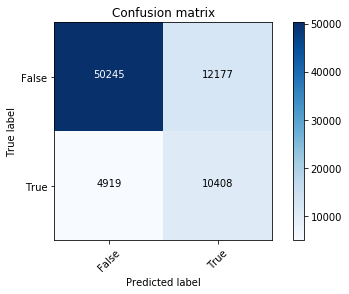

In [19]:
from classification_plots import plot_confusion_matrix
from matplotlib.
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    pred = list(hl_shallow[h_classes[i]].predict(test_X))
    print(str(h_classes[i]) + ": " + 
          str(metrics.accuracy_score(test_y.between(start_i, end_i), pred)))
    
    cm = metrics.confusion_matrix(test_y.between(start_i, end_i), pred)
    plot_confusion_matrix(cm, ['False', 'True'])
    plt.show()

# Low-Level Deep Net

In [16]:
import dnn_classifier as dnn_clas
hl_deep = {}
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    tmp = train_y.between(start_i, end_i)
    this_train_y = train_y[tmp] - start_i
    this_train_X = train_X[tmp]
    tmp = test_y.between(start_i, end_i)
    this_test_y = test_y[tmp] - start_i
    this_test_X = test_X[tmp]
    clas = KerasClassifier(build_fn=dnn_clas.create_baseline, epochs=20, batch_size=128, verbose=1)
    clas.fit(this_train_X, this_train_y)
    clas.score(this_test_X, this_test_y)
    hl_deep[h_classes[i]] = clas

NameError: name 'hl_deep' is not defined

## Scoring
Here we get the log likelihood of the categories when matched with its training data

In [ ]:
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    tmp = test_y.between(start_i, end_i)
    this_test_y = test_y[tmp] - start_i
    this_test_X = test_X[tmp]
    pred = list(hl_deep[h_classes[i]].predict(this_test_X))
    print(str(h_classes[i]) + ": " + 
          str(metrics.accuracy_score(this_test_y, pred)))
    
    cm = metrics.confusion_matrix(test_y[tmp], np.array(pred) + start_i)
    plot_confusion_matrix(cm, classes[start_i:end_i])
    plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [ ]:
res_shallow_y = [None] * 5
res_deep_y = [None] * 5
for i in range(0,5):
    res_shallow_y[i] = list(hl_shallow[h_classes[i]].predict(test_X))
    res_deep_y[i] = list(hl_deep[h_classes[i]].predict(test_X))

In [ ]:
print(res_shallow_y)

In [ ]:
print(res_deep_y)

In [ ]:
res_y = [0] * len(res_shallow_y[0])
for i in range(0, len(res_y)):
    if res_shallow_y[0][i] == 1:
        res_y[i] = res_deep_y[0][i]
    elif res_shallow_y[1][i] == 1:
        res_y[i] = res_deep_y[1][i] + 10
    elif res_shallow_y[2][i] == 1:
        res_y[i] = res_deep_y[2][i] + 20
    elif res_shallow_y[3][i] == 1:
        res_y[i] = res_deep_y[3][i] + 30
    elif res_shallow_y[4][i] == 1:
        res_y[i] = res_deep_y[4][i] + 40

In [ ]:
print(res_y)

In [ ]:
from classification_plots import plot_confusion_matrix
cm = metrics.confusion_matrix(test_y, res_y)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plot_confusion_matrix(cm, classes)

## Basic Probability of File Category
We run our classifier over the file's audio frames and use basic averages to determine the probability of it belonging to a class. (Should in future have classifier give probability scores for each category for each frame but... thats future work)

In [ ]:
print(classes)

In [ ]:
from collections import Counter
def file_probability(filename, clas, preprocessor, class_list):
    test_file = pd.DataFrame(preprocessor.preprocess(filename))
    predictions = [class_list[i] for i in list(clas.predict(test_file))]
    sns.countplot(predictions)
    c = Counter(predictions)
    return [(i, c[i] / len(predictions) * 100.0) for i, count in c.most_common()]

In [ ]:
plt.figure(figsize=(10,10))
file = dataset.filename.sample(n=1).values[0]
file_probability(file, clas, preprocess, classes)

In [ ]:
dataset[dataset.filename == file]